<a href="https://colab.research.google.com/github/krdpk17/first_simple_network/blob/main/Erav1_assignment_7_s3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Step 3

Use the adaptive global average pooling

---



In [ ]:
!pip install torchsummary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [ ]:

# Transforms for training data
train_transforms = transforms.Compose([
    transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,),(0.3081,))
])

# Transforms for testing data
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,),(0.3081,))
])



In [ ]:
#download train and test data
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

100%|██████████| 9912422/9912422 [00:00<00:00, 129134360.32it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 122855673.25it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 39072832.75it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 2479891.79it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
#check if cuda available
cuda = torch.cuda.is_available()
print('cuda available = ', cuda)

cuda available =  True


In [ ]:
#for reproducibility
SEED = 1
torch.manual_seed(SEED)
print("Cuda=", cuda)
if cuda:
  torch.cuda.manual_seed(SEED)

Cuda= True


In [ ]:
#data loader
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

train_loader = torch.utils.data.DataLoader(train, **dataloader_args)
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU()
        ) # output_size = 8

        # OUTPUT BLOCK
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 6

        self.gap = nn.Sequential(
            nn.AdaptiveAvgPool2d((1,1))
            # nn.BatchNorm2d(10), NEVER
            # nn.ReLU() NEVER!
        ) # output_size = 1X1*16

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False)
        ) # output_size = 6
        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.dropout(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.gap(x)
        x = self.convblock8(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [ ]:
from torchsummary import summary

device = torch.device("cuda" if cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
       BatchNorm2d-3           [-1, 16, 26, 26]              32
           Dropout-4           [-1, 16, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           2,304
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             160
          Dropout-10           [-1, 10, 24, 24]               0
        MaxPool2d-11           [-1, 10, 12, 12]               0
           Conv2d-12           [-1, 16, 10, 10]           1,440
             ReLU-13           [-1, 16, 10, 10]               0
      BatchNorm2d-14           [-1

In [ ]:
#training and testing methods
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    #move data and target to device
    data, target = data.to(device), target.to(device)

    #reset gradient values to zero
    optimizer.zero_grad()

    y_pred = model(data) # prediction

    loss = F.nll_loss(y_pred, target=target) # calculate loss/error
    train_losses.append(loss)

    loss.backward() # calculate back propagation
    optimizer.step() # apply the back propagation


    pred = y_pred.argmax(dim=1, keepdim=True)
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      output = model(data)

      test_loss = F.nll_loss(output, target=target, reduction='sum').item()
      pred = output.argmax(dim=1, keepdim=True)
      correct += pred.eq(target.view_as(pred)).sum().item()

      test_loss /= len(test_loader.dataset)
      test_losses.append(test_loss)

  print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

  test_acc.append(100*correct/len(test_loader.dataset))


In [ ]:
from torch.optim.lr_scheduler import StepLR

#train and test the model
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

EPOCHS = 20
for epoch in range(EPOCHS):
  print("EPOCH:", epoch)
  train(model,device, train_loader=train_loader, optimizer=optimizer, epoch=epoch)
  test(model, device, test_loader= test_loader)

EPOCH: 0


Loss=0.24305547773838043 Batch_id=468 Accuracy=86.15: 100%|██████████| 469/469 [00:22<00:00, 20.42it/s]



Test set: Average loss: 0.0001, Accuracy: 9532/10000 (95.32%)

EPOCH: 1


Loss=0.08686795085668564 Batch_id=468 Accuracy=97.25: 100%|██████████| 469/469 [00:21<00:00, 22.18it/s]



Test set: Average loss: 0.0000, Accuracy: 9795/10000 (97.95%)

EPOCH: 2


Loss=0.09648805856704712 Batch_id=468 Accuracy=97.85: 100%|██████████| 469/469 [00:21<00:00, 21.61it/s]



Test set: Average loss: 0.0001, Accuracy: 9784/10000 (97.84%)

EPOCH: 3


Loss=0.04690079391002655 Batch_id=468 Accuracy=98.13: 100%|██████████| 469/469 [00:22<00:00, 21.00it/s]



Test set: Average loss: 0.0000, Accuracy: 9866/10000 (98.66%)

EPOCH: 4


Loss=0.09036623686552048 Batch_id=468 Accuracy=98.36: 100%|██████████| 469/469 [00:22<00:00, 20.70it/s]



Test set: Average loss: 0.0000, Accuracy: 9889/10000 (98.89%)

EPOCH: 5


Loss=0.09972512722015381 Batch_id=468 Accuracy=98.52: 100%|██████████| 469/469 [00:22<00:00, 20.61it/s]



Test set: Average loss: 0.0000, Accuracy: 9893/10000 (98.93%)

EPOCH: 6


Loss=0.05056499317288399 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:23<00:00, 20.19it/s]



Test set: Average loss: 0.0001, Accuracy: 9853/10000 (98.53%)

EPOCH: 7


Loss=0.029505714774131775 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:22<00:00, 20.85it/s]



Test set: Average loss: 0.0000, Accuracy: 9880/10000 (98.80%)

EPOCH: 8


Loss=0.03122163563966751 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:21<00:00, 21.49it/s]



Test set: Average loss: 0.0000, Accuracy: 9851/10000 (98.51%)

EPOCH: 9


Loss=0.04271369054913521 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:21<00:00, 22.21it/s]



Test set: Average loss: 0.0001, Accuracy: 9878/10000 (98.78%)

EPOCH: 10


Loss=0.046850889921188354 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:21<00:00, 21.49it/s]



Test set: Average loss: 0.0002, Accuracy: 9862/10000 (98.62%)

EPOCH: 11


Loss=0.030190253630280495 Batch_id=468 Accuracy=98.82: 100%|██████████| 469/469 [00:23<00:00, 19.67it/s]



Test set: Average loss: 0.0001, Accuracy: 9889/10000 (98.89%)

EPOCH: 12


Loss=0.016583045944571495 Batch_id=468 Accuracy=98.85: 100%|██████████| 469/469 [00:21<00:00, 21.39it/s]



Test set: Average loss: 0.0000, Accuracy: 9900/10000 (99.00%)

EPOCH: 13


Loss=0.12206200510263443 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:22<00:00, 21.09it/s]



Test set: Average loss: 0.0000, Accuracy: 9906/10000 (99.06%)

EPOCH: 14


Loss=0.045463234186172485 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:22<00:00, 21.29it/s]



Test set: Average loss: 0.0001, Accuracy: 9870/10000 (98.70%)

EPOCH: 15


Loss=0.01127390656620264 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:21<00:00, 22.19it/s]



Test set: Average loss: 0.0001, Accuracy: 9894/10000 (98.94%)

EPOCH: 16


Loss=0.014173842966556549 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:20<00:00, 22.40it/s]



Test set: Average loss: 0.0000, Accuracy: 9907/10000 (99.07%)

EPOCH: 17


Loss=0.020188456401228905 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:23<00:00, 20.34it/s]



Test set: Average loss: 0.0000, Accuracy: 9906/10000 (99.06%)

EPOCH: 18


Loss=0.06665913015604019 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:21<00:00, 21.37it/s]



Test set: Average loss: 0.0000, Accuracy: 9907/10000 (99.07%)

EPOCH: 19


Loss=0.11492994427680969 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:21<00:00, 21.70it/s]



Test set: Average loss: 0.0000, Accuracy: 9919/10000 (99.19%)



Text(0.5, 1.0, 'Test Accuracy')

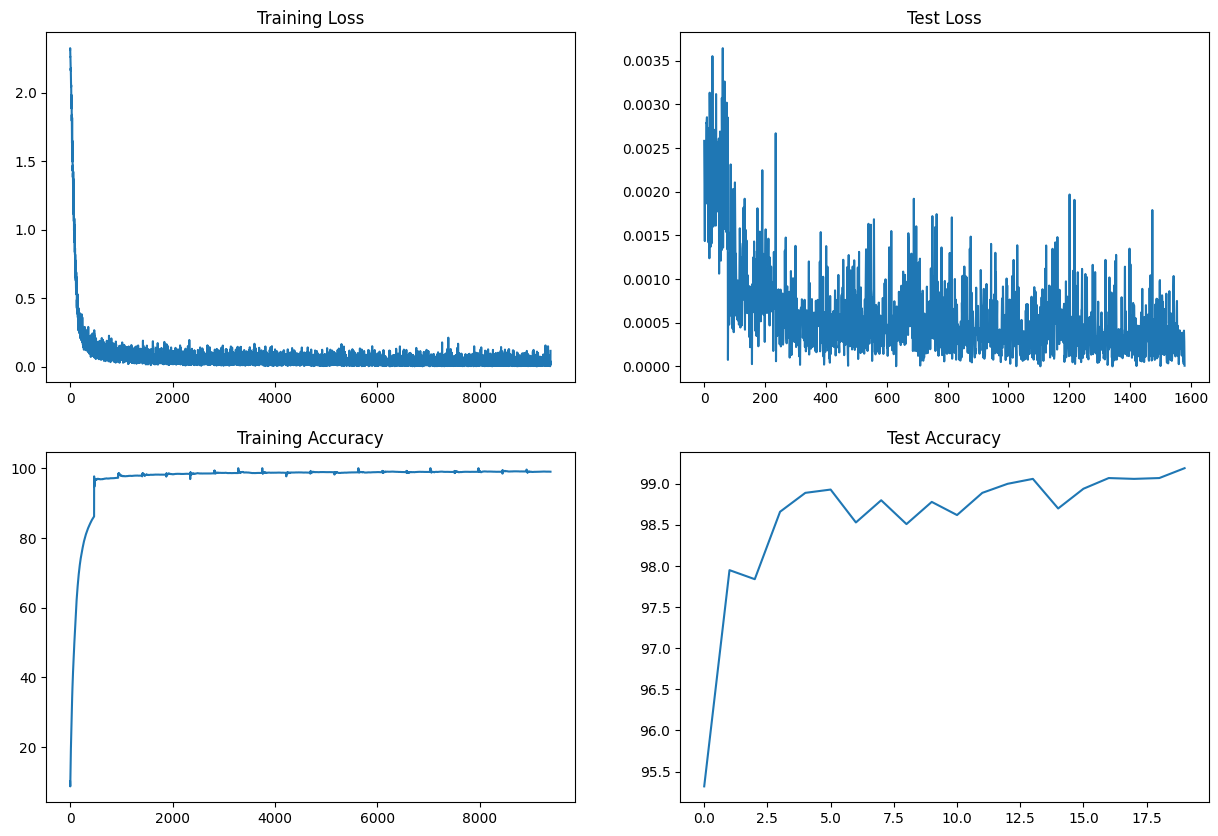

In [ ]:
t = [t_items.item() for t_items in train_losses]
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

Parameters: 8,976

Best training accuracy: 99.19

Best test accuracy:98.99

Observations

Test and training accuracy is not as good as previous experiment




Next step:

Discard this approach


